In [54]:
# 쉬는날을 찾기

import random
import pandas as pd
import numpy as np
import os
import holidays

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore') 
korea_holidays = holidays.SouthKorea(years=2023)

In [55]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [56]:
train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')

target = []
for date, name in sorted(korea_holidays.items()):
    target.append(str(date))
train['Isholiday'] = train['timestamp'].apply(lambda x: 1 if x in target else 0)
test['Isholiday'] = test['timestamp'].apply(lambda x: 1 if x in target else 0)

train = train.drop(train[(train['supply(kg)'] > 0) & (train['price(원/kg)'] == 0)].index)
train = train.reset_index(drop=True)

train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])
train['Is_Sunday'] = train['timestamp'].dt.day_name() == 'Sunday'
test['Is_Sunday'] = test['timestamp'].dt.day_name() == 'Sunday'

# no supply -> no price
train['classify'] = train['supply(kg)'].apply(lambda x: 0 if x == 0 else 1)
train['Is_Sunday'] = train['Is_Sunday'].apply(lambda x: 0 if x == False else 1)    
test['Is_Sunday'] = test['Is_Sunday'].apply(lambda x: 0 if x == False else 1)    

train['timestamp'] = train['timestamp'].astype('str')
train['year'] = train['timestamp'].apply(lambda x : int(x[0:4]))
train['month'] = train['timestamp'].apply(lambda x : int(x[5:7]))
train['day'] = train['timestamp'].apply(lambda x : int(x[8:10]))

test['timestamp'] = test['timestamp'].astype('str')
test['year'] = test['timestamp'].apply(lambda x : int(x[0:4]))
test['month'] = test['timestamp'].apply(lambda x : int(x[5:7]))
test['day'] = test['timestamp'].apply(lambda x : int(x[8:10]))

qual_col = ['item', 'corporation', 'location']

for i in qual_col:
    le = LabelEncoder()
    train[i]=le.fit_transform(train[i])
    test[i]=le.transform(test[i]) #test 데이터에 대해서 fit하는 것은 data leakage에 해당합니다

train = train.drop(['supply(kg)','price(원/kg)','ID','timestamp'],axis=1)
test = test.drop(['ID','timestamp'],axis=1)
print('Done.')

Done.


In [57]:
from pycaret import classification
classification.setup(data=train,target='classify'
                     ,train_size=0.8
                     ,fold=5
                     ,fold_strategy='kfold'
                     ,data_split_shuffle=True
                     ,session_id=42)

,Description,Value
0,Session id,42
1,Target,classify
2,Target type,Binary
3,Original data shape,"(59394, 9)"
4,Transformed data shape,"(59394, 9)"
5,Transformed train set shape,"(47515, 9)"
6,Transformed test set shape,"(11879, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


In [58]:
best = classification.compare_models(n_select=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9379,0.9849,0.9476,0.9031,0.9248,0.8720,0.8727,1.6580
catboost,CatBoost Classifier,0.9366,0.9843,0.9472,0.9007,0.9234,0.8694,0.8702,11.7520
rf,Random Forest Classifier,0.9358,0.9813,0.9326,0.9104,0.9214,0.8671,0.8673,1.3580
lightgbm,Light Gradient Boosting Machine,0.9331,0.9827,0.9523,0.8896,0.9198,0.8625,0.8640,0.3820
et,Extra Trees Classifier,0.9328,0.9785,0.9287,0.9068,0.9176,0.8608,0.8610,1.3480
dt,Decision Tree Classifier,0.9176,0.9144,0.8975,0.8981,0.8978,0.8288,0.8288,0.0360
gbc,Gradient Boosting Classifier,0.9043,0.9609,0.8963,0.8702,0.8830,0.8020,0.8023,1.5820
knn,K Neighbors Classifier,0.8989,0.9531,0.8998,0.8566,0.8776,0.7915,0.7922,0.6100
ada,Ada Boost Classifier,0.8511,0.9305,0.7732,0.8443,0.8072,0.6863,0.6881,0.6780
ridge,Ridge Classifier,0.7576,0.0000,0.6807,0.7071,0.6936,0.4932,0.4935,0.0600


In [59]:
best[0].classes_

array([0, 1], dtype=int8)

<Axes: ylabel='Frequency'>

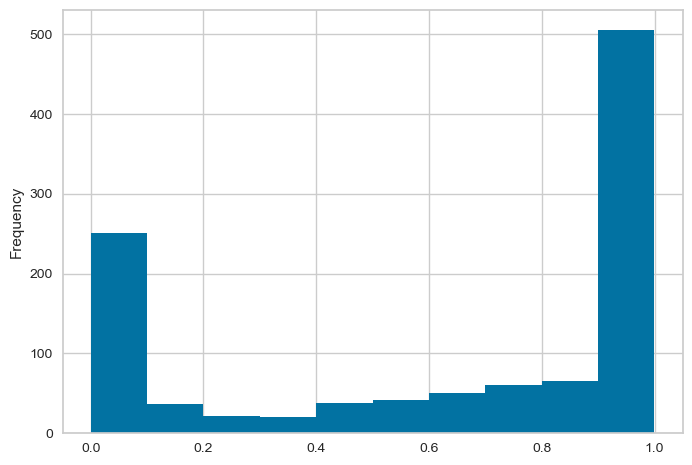

In [60]:
pred = ((best[0].predict_proba(test)) + best[1].predict_proba(test) + best[2].predict_proba(test))/3
pd.DataFrame(pred)[1].plot.hist()

In [61]:
answer = []
for i in pred:
    if i[1] > 0.2:
        answer.append(0)
    else:
        answer.append(1)
test['classify'] = answer
test

,item,corporation,location,Isholiday,Is_Sunday,year,month,day,classify
0,4,0,0,0,0,2023,3,4,0
1,4,0,0,0,1,2023,3,5,1
2,4,0,0,0,0,2023,3,6,0
3,4,0,0,0,0,2023,3,7,0
4,4,0,0,0,0,2023,3,8,0
...,...,...,...,...,...,...,...,...,...
1087,3,5,0,0,0,2023,3,27,0
1088,3,5,0,0,0,2023,3,28,0
1089,3,5,0,0,0,2023,3,29,0
1090,3,5,0,0,0,2023,3,30,0


In [62]:
tp = test[(test['classify'] == 1) & (test['Is_Sunday'] == 0) & (test['Isholiday'] == 0)]
tp.groupby(['location','item','corporation']).count()

Isholiday  Is_Sunday  year  month  day  classify
location item corporation                                                  
1        0    1                   21         21    21     21   21        21
              2                   24         24    24     24   24        24
         1    0                   17         17    17     17   17        17
         2    3                   24         24    24     24   24        24
              4                   24         24    24     24   24        24
         3    2                   22         22    22     22   22        22

In [63]:
train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')

target = []
for date, name in sorted(korea_holidays.items()):
    target.append(str(date))
train['Isholiday'] = train['timestamp'].apply(lambda x: 1 if x in target else 0)
test['Isholiday'] = test['timestamp'].apply(lambda x: 1 if x in target else 0)

train = train.drop(train[(train['supply(kg)'] > 0) & (train['price(원/kg)'] == 0)].index)
train = train.reset_index(drop=True)

train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])
train['Is_Sunday'] = train['timestamp'].dt.day_name() == 'Sunday'
test['Is_Sunday'] = test['timestamp'].dt.day_name() == 'Sunday'

# no supply -> no price
train['classify'] = train['supply(kg)'].apply(lambda x: 0 if x == 0 else 1)
train['Is_Sunday'] = train['Is_Sunday'].apply(lambda x: 0 if x == False else 1)    
test['Is_Sunday'] = test['Is_Sunday'].apply(lambda x: 0 if x == False else 1)    

train['timestamp'] = train['timestamp'].astype('str')
train['year'] = train['timestamp'].apply(lambda x : int(x[0:4]))
train['month'] = train['timestamp'].apply(lambda x : int(x[5:7]))
train['day'] = train['timestamp'].apply(lambda x : int(x[8:10]))

test['timestamp'] = test['timestamp'].astype('str')
test['year'] = test['timestamp'].apply(lambda x : int(x[0:4]))
test['month'] = test['timestamp'].apply(lambda x : int(x[5:7]))
test['day'] = test['timestamp'].apply(lambda x : int(x[8:10]))

qual_col = ['item', 'corporation', 'location']

for i in qual_col:
    le = LabelEncoder()
    train[i]=le.fit_transform(train[i])
    test[i]=le.transform(test[i]) #test 데이터에 대해서 fit하는 것은 data leakage에 해당합니다

train = train.drop(['supply(kg)','ID','timestamp'],axis=1)
test = test.drop(['ID','timestamp'],axis=1)

answer = []
for i in pred:
    if i[1] > 0.5:
        answer.append(1)
    else:
        answer.append(0)
test['classify'] = answer

train_feed = train.drop(['price(원/kg)','classify'],axis=1)
train_feed['classify'] = train['classify']
train_feed['price(원/kg)'] = train['price(원/kg)']

print('Done.')

Done.


In [64]:
train_feed

,item,corporation,location,Isholiday,Is_Sunday,year,month,day,classify,price(원/kg)
0,4,0,0,0,0,2019,1,1,0,0.0
1,4,0,0,0,0,2019,1,2,0,0.0
2,4,0,0,0,0,2019,1,3,1,1728.0
3,4,0,0,0,0,2019,1,4,1,1408.0
4,4,0,0,0,0,2019,1,5,1,1250.0
...,...,...,...,...,...,...,...,...,...,...
59389,3,5,0,0,0,2023,2,27,1,468.0
59390,3,5,0,0,0,2023,2,28,1,531.0
59391,3,5,0,1,0,2023,3,1,1,574.0
59392,3,5,0,0,0,2023,3,2,1,523.0


In [65]:
test

,item,corporation,location,Isholiday,Is_Sunday,year,month,day,classify
0,4,0,0,0,0,2023,3,4,1
1,4,0,0,0,1,2023,3,5,0
2,4,0,0,0,0,2023,3,6,1
3,4,0,0,0,0,2023,3,7,1
4,4,0,0,0,0,2023,3,8,1
...,...,...,...,...,...,...,...,...,...
1087,3,5,0,0,0,2023,3,27,1
1088,3,5,0,0,0,2023,3,28,1
1089,3,5,0,0,0,2023,3,29,1
1090,3,5,0,0,0,2023,3,30,1


In [66]:
from pycaret import regression
regression.setup(data=train_feed,target='price(원/kg)'
                     ,train_size=0.8
                     ,fold=5
                     ,session_id=42)

,Description,Value
0,Session id,42
1,Target,price(원/kg)
2,Target type,Regression
3,Original data shape,"(59394, 10)"
4,Transformed data shape,"(59394, 10)"
5,Transformed train set shape,"(47515, 10)"
6,Transformed test set shape,"(11879, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


In [67]:
best = regression.compare_models(n_select=10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,141.5625,188405.4143,433.4950,0.9544,0.1269,0.1385,2.0000
et,Extra Trees Regressor,142.9333,199774.3141,446.0650,0.9516,0.1283,0.1368,1.6480
xgboost,Extreme Gradient Boosting,188.8253,210327.0406,458.2459,0.9491,2.3801,0.2012,1.7240
catboost,CatBoost Regressor,186.0557,213730.1833,461.9675,0.9483,2.0909,0.2033,5.7360
lightgbm,Light Gradient Boosting Machine,178.2919,215497.3818,463.8833,0.9479,1.1527,0.2081,0.2440
dt,Decision Tree Regressor,180.5643,323658.7052,568.1480,0.9217,0.1620,0.1705,0.0840
gbr,Gradient Boosting Regressor,320.2768,413677.2108,642.9114,0.8999,2.9559,0.4228,1.3820
knn,K Neighbors Regressor,354.9058,605573.0375,777.8973,0.8535,1.9210,0.4926,0.3460
ada,AdaBoost Regressor,504.0395,1056568.7955,1024.6822,0.7438,0.4672,0.9225,0.8540
ridge,Ridge Regression,891.9925,2083592.7444,1443.3752,0.4956,4.1654,1.5539,0.0460


In [68]:
test['price(원/kg)'] = (best[0].predict(test) + best[1].predict(test) + best[2].predict(test))/3
test

,item,corporation,location,Isholiday,Is_Sunday,year,month,day,classify,price(원/kg)
0,4,0,0,0,0,2023,3,4,1,3958.948577
1,4,0,0,0,1,2023,3,5,0,20.766754
2,4,0,0,0,0,2023,3,6,1,3851.386576
3,4,0,0,0,0,2023,3,7,1,3644.788669
4,4,0,0,0,0,2023,3,8,1,3269.895798
...,...,...,...,...,...,...,...,...,...,...
1087,3,5,0,0,0,2023,3,27,1,501.893952
1088,3,5,0,0,0,2023,3,28,1,511.165369
1089,3,5,0,0,0,2023,3,29,1,517.532590
1090,3,5,0,0,0,2023,3,30,1,512.039886


<Axes: >

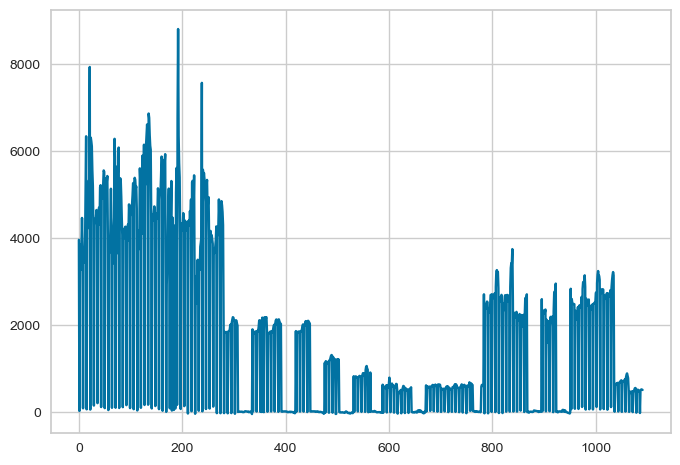

In [69]:
test['price(원/kg)'].plot()

In [70]:
submission = pd.read_csv('./open/sample_submission.csv')
submission['answer'] = test['price(원/kg)']
submission.to_csv('./cl-rg.csv', index=False)


In [75]:
train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')

target = []
for date, name in sorted(korea_holidays.items()):
    target.append(str(date))
train['Isholiday'] = train['timestamp'].apply(lambda x: 1 if x in target else 0)
test['Isholiday'] = test['timestamp'].apply(lambda x: 1 if x in target else 0)

train = train.drop(train[(train['supply(kg)'] > 0) & (train['price(원/kg)'] == 0)].index)
train = train.reset_index(drop=True)

train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])
train['Is_Sunday'] = train['timestamp'].dt.day_name() == 'Sunday'
test['Is_Sunday'] = test['timestamp'].dt.day_name() == 'Sunday'

# no supply -> no price
# train['classify'] = train['supply(kg)'].apply(lambda x: 0 if x == 0 else 1)
train['Is_Sunday'] = train['Is_Sunday'].apply(lambda x: 0 if x == False else 1)    
test['Is_Sunday'] = test['Is_Sunday'].apply(lambda x: 0 if x == False else 1)    

train['timestamp'] = train['timestamp'].astype('str')
train['year'] = train['timestamp'].apply(lambda x : int(x[0:4]))
train['month'] = train['timestamp'].apply(lambda x : int(x[5:7]))
train['day'] = train['timestamp'].apply(lambda x : int(x[8:10]))

test['timestamp'] = test['timestamp'].astype('str')
test['year'] = test['timestamp'].apply(lambda x : int(x[0:4]))
test['month'] = test['timestamp'].apply(lambda x : int(x[5:7]))
test['day'] = test['timestamp'].apply(lambda x : int(x[8:10]))

qual_col = ['item', 'corporation', 'location']

for i in qual_col:
    le = LabelEncoder()
    train[i]=le.fit_transform(train[i])
    test[i]=le.transform(test[i]) #test 데이터에 대해서 fit하는 것은 data leakage에 해당합니다

train = train.drop(['supply(kg)','ID','timestamp'],axis=1)
test = test.drop(['ID','timestamp'],axis=1)
print('Done.')

Done.


In [76]:
from pycaret import regression
regression.setup(data=train,target='price(원/kg)'
                     ,train_size=0.8
                     ,fold=5
                     ,session_id=42)

,Description,Value
0,Session id,42
1,Target,price(원/kg)
2,Target type,Regression
3,Original data shape,"(59394, 9)"
4,Transformed data shape,"(59394, 9)"
5,Transformed train set shape,"(47515, 9)"
6,Transformed test set shape,"(11879, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


In [77]:
best = regression.compare_models(n_select=10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,427.1465,817317.7250,903.8935,0.8021,3.7634,0.2542,1.6080
rf,Random Forest Regressor,320.0728,822783.3997,906.7267,0.8007,2.1163,0.1972,2.8480
catboost,CatBoost Regressor,438.0389,836949.4290,914.6406,0.7973,3.7940,0.2601,5.6420
lightgbm,Light Gradient Boosting Machine,420.5735,836999.2521,914.6822,0.7973,3.5597,0.2708,0.2500
et,Extra Trees Regressor,315.1599,931487.6845,964.3770,0.7744,1.9330,0.1964,2.2680
gbr,Gradient Boosting Regressor,604.7243,1201150.9185,1095.8397,0.7091,4.2279,0.3339,1.3260
knn,K Neighbors Regressor,628.9727,1341125.6250,1157.9365,0.6753,3.5050,0.4358,0.3460
dt,Decision Tree Regressor,373.0295,1379089.0381,1174.2202,0.6661,2.1077,0.2524,0.0980
ada,AdaBoost Regressor,1016.2261,2114559.9268,1453.1139,0.4878,4.9809,0.5086,0.8920
br,Bayesian Ridge,1317.3609,3323346.0121,1822.9393,0.1954,5.1637,0.9835,0.0480


In [78]:
test['price(원/kg)'] = (best[0].predict(test) + best[1].predict(test) + best[2].predict(test))/3
test

,item,corporation,location,Isholiday,Is_Sunday,year,month,day,price(원/kg)
0,4,0,0,0,0,2023,3,4,3591.946802
1,4,0,0,0,1,2023,3,5,-150.773738
2,4,0,0,0,0,2023,3,6,3645.641955
3,4,0,0,0,0,2023,3,7,3656.795747
4,4,0,0,0,0,2023,3,8,3535.212392
...,...,...,...,...,...,...,...,...,...
1087,3,5,0,0,0,2023,3,27,510.761816
1088,3,5,0,0,0,2023,3,28,486.562725
1089,3,5,0,0,0,2023,3,29,479.318659
1090,3,5,0,0,0,2023,3,30,462.199248


In [95]:
submission = pd.read_csv('./open/sample_submission.csv')
submission['answer'] = test['price(원/kg)']
submission.to_csv('./holiday-rg.csv', index=False)

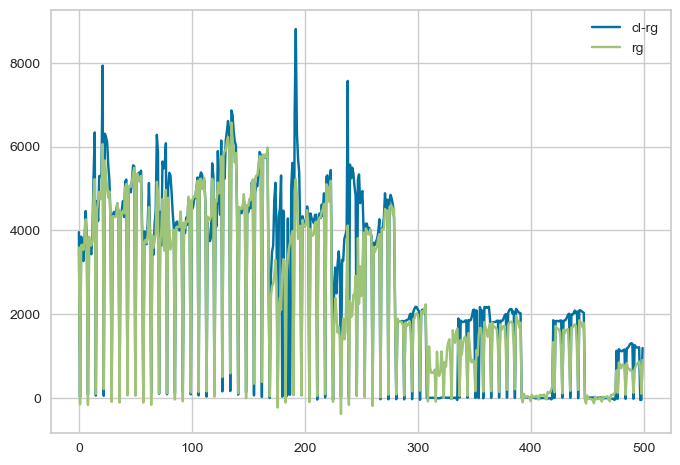

In [97]:
s = 0
e = 500
plt.plot(pd.read_csv('./cl-rg.csv')['answer'][s:e])
test['price(원/kg)'][s:e].plot()
# plt.plot(pd.read_csv('./baseline_submission.csv')['answer'][s:e])
plt.legend(['cl-rg','rg','base'])

In [114]:
check = pd.DataFrame(columns=['datetime','cl-rg','rg','base'])
check['datetime'] = pd.read_csv('./open/test.csv')['timestamp']
check['cl-rg'] = pd.read_csv('./cl-rg.csv')['answer']
check['rg'] = test['price(원/kg)']
check['base'] = pd.read_csv('./baseline_submission.csv')['answer']
check['classify'] = answer
check['Isholiday'] = test['Isholiday']
check['Is_Sunday'] = test['Is_Sunday']
check[check['classify'] == 0][:50]

,datetime,cl-rg,rg,base,classify,Isholiday,Is_Sunday
1,2023-03-05,20.766754,-150.773738,4109.28,0,0,1
8,2023-03-12,82.367645,-164.554250,3387.97,0,0,1
15,2023-03-19,58.608353,96.850214,4363.36,0,0,1
22,2023-03-26,52.386607,212.102738,6496.81,0,0,1
29,2023-03-05,145.145498,-93.675831,4155.17,0,0,1
36,2023-03-12,200.802653,-108.394384,4332.56,0,0,1
43,2023-03-19,111.049835,63.870779,4566.69,0,0,1
50,2023-03-26,86.191101,55.699026,5150.34,0,0,1
57,2023-03-05,41.341357,-108.340289,4386.02,0,0,1
64,2023-03-12,93.567373,-163.105952,4153.45,0,0,1


In [115]:
check.loc[check[(check['rg'] < 0)].index,'rg'] = 0
check[:50]

,datetime,cl-rg,rg,base,classify,Isholiday,Is_Sunday
0,2023-03-04,3958.948577,3591.946802,3636.64,1,0,0
1,2023-03-05,20.766754,0.000000,4109.28,0,0,1
2,2023-03-06,3851.386576,3645.641955,401.82,1,0,0
3,2023-03-07,3644.788669,3656.795747,3277.93,1,0,0
4,2023-03-08,3269.895798,3535.212392,3067.03,1,0,0
5,2023-03-09,3803.169860,3715.112540,3332.58,1,0,0
6,2023-03-10,4461.922243,4265.172724,3810.00,1,0,0
7,2023-03-11,3782.367031,3687.944411,3417.53,1,0,0
8,2023-03-12,82.367645,0.000000,3387.97,0,0,1
9,2023-03-13,3768.580495,3848.163018,455.27,1,0,0


In [116]:
submission = pd.read_csv('./open/sample_submission.csv')
submission['answer'] = check['rg'] 
submission.to_csv('./rg-remove-negative.csv', index=False)
